In [1]:
#Package install
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def points_projection(z,n):
  z = np.array(z)
  n = np.array(n)
  
  #Find two orthogonal vectors u and v (both orthogonal to n)
  #Calc value for t (random vector), ensuring not a scaled version of n
  if n[0] != 0:
    t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
  elif n[1] != 0:
    t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
  else:
    t = np.array([-(n[0]+n[1]) / n[2], 1, 1])

  u = np.cross(t,n)
  v = np.cross(n,u)

  # Normalize u and v (length become 1 unit long)
  u = u / np.linalg.norm(u)
  v = v / np.linalg.norm(v)

  vec_mat = np.array([u,v])

  #Project structure points onto plane
  #Individual component of normal
  a = n[0]
  b = n[1]
  c = n[2]
  d = 0

  projected_points = []
  for point in z:
    z1,z2,z3 = point

    k = (d - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 

    p1 = z1 + k*a
    p2 = z2 + k*b
    p3 = z3 + k*c

    p = np.array([p1,p2,p3])
  
    #Convert 3D points to 2D
    p_trans = p.transpose()
    proj_2d = np.dot(vec_mat,p_trans)

    projected_points.append(proj_2d)

  return np.array(projected_points)

In [12]:
#Testing
#coords for a cube
z = [(0, 0, 0), (1, 0, 0), (1, 1, 0), (0, 1, 0), (0, 0, 1), (1, 0, 1), (1, 1, 1),  (0, 1, 1)]
z = np.array(z)
n = [1,0,1]

projects = points_projection(z,n)
print(projects)

[[ 0.          0.        ]
 [ 0.40824829 -0.57735027]
 [ 1.22474487  0.        ]
 [ 0.81649658  0.57735027]
 [-0.40824829  0.57735027]
 [ 0.          0.        ]
 [ 0.81649658  0.57735027]
 [ 0.40824829  1.15470054]]


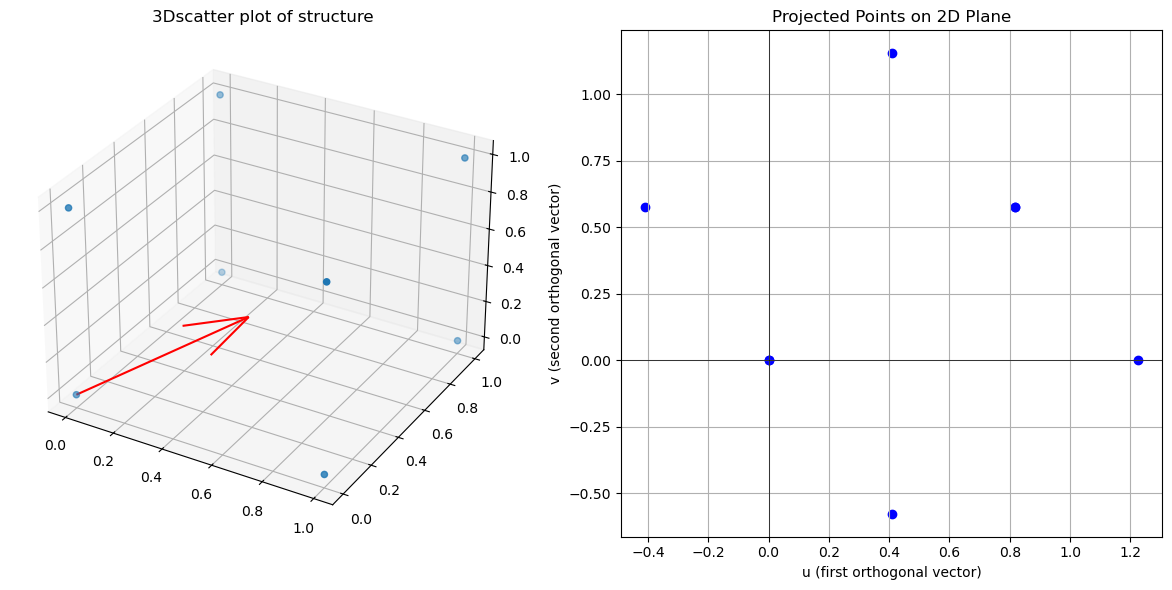

In [13]:
#Check structure
#Plot Z in 3D
fig = plt.figure(figsize=(12, 6))

#Plot 3-D projection
ax1 = fig.add_subplot(121,projection ='3d')
ax1.scatter3D(z[:, 0], z[:, 1], z[:, 2], 'green')
ax1.set_title('3Dscatter plot of structure')

origin = np.array([0,0,0])
ax1.quiver(origin[0],origin[1],origin[2],n[0],n[1],n[2], color='red', length=1, normalize=True)

#Plot 2D coords
ax2 = fig.add_subplot(122)
ax2.scatter(projects[:, 0], projects[:, 1], c='blue', marker='o')
ax2.set_title('Projected Points on 2D Plane')
ax2.set_xlabel('u (first orthogonal vector)')
ax2.set_ylabel('v (second orthogonal vector)')
ax2.grid(True)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

In [14]:
# Transform projected points into image with 1s and 0s
def image_projection(coords, size):
    projects = np.array(coords)
    image_size = size
    
    #Normalise 2D coords for better scalling (between 0-1)
    min_val = np.min(projects, axis=0)
    max_val = np.max(projects, axis=0)
    
    #Feature scaling 
    points_norm = (projects - min_val) / (max_val - min_val) 
    
    # Scale points to image size
    points_scaled = (points_norm * (np.array(image_size) -1 )).astype(int)
    
    # Create an empty image
    image = np.zeros(image_size)
    
    # Populate the image with points
    for point in points_scaled:
        x, y = point
        image[y,x] = 1  # Note: (y, x) because image coordinates are row-major
    
    #Plot image
    plt.imshow(image, cmap='gray')
    plt.title('Projected Points Image')
    plt.show()
    
    return points_scaled

# Counting points per cell

In [16]:
#Place projected points into grid and count points per grid cell 
def cluster_per_cell(projected_points, image_size, grid_size):
    projection = np.array(projected_points)
    image_size = image_size
    grid_x = grid_size[0]
    grid_y = grid_size[1]
    
    grid = np.zeros((grid_x,grid_y), dtype=int)
    
    #Calc size of grid cell
    cell_x = image_size[0] / grid_x
    cell_y = image_size[1] / grid_y

    #Normalise 2D coords for better scalling (between 0-1)
    min_val = np.min(projection, axis=0)
    max_val = np.max(projection, axis=0)
    
    #Feature scaling 
    points_norm = (projection - min_val) / (max_val - min_val) 
    
    scaled_points = (points_norm * (np.array(image_size) - 1)).astype(int)
    
    for points in scaled_points:
        x,y = points
        gridx_index = int(x // cell_x) #floor division followed by conversion to integer
        gridy_index = int(y // cell_y)
        grid[gridy_index, gridx_index] += 1

    # Plot the image and grid
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Draw the grid
    for row in range(grid_y + 1):
        ax.axhline(row * cell_y, color='black', linewidth=0.5)
    for col in range(grid_x + 1):
        ax.axvline(col * cell_x, color='black', linewidth=0.5)
    
    plt.gca().invert_yaxis()

    #Plot the points 
    ax.scatter(scaled_points[:,0], scaled_points[:,1], c="red", marker="." )
    
    #Plot numbers on grid
    for i in range(len(grid)):
        for j in range(len(grid)):
            ax.text( j * cell_y +(cell_y / 2), i * cell_x + (cell_x / 2), 
                    grid[i,j], fontsize = 20, color='blue', ha='center', va='center')
    
    #print numbers at coords????
    
    #set axis labels
    ax.set_xlim(0 , image_size[1])
    ax.set_ylim(image_size[0], 0)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title(f'Points Distribution with Grid Size: {image_size}')
    
   
    plt.show()

    return  grid

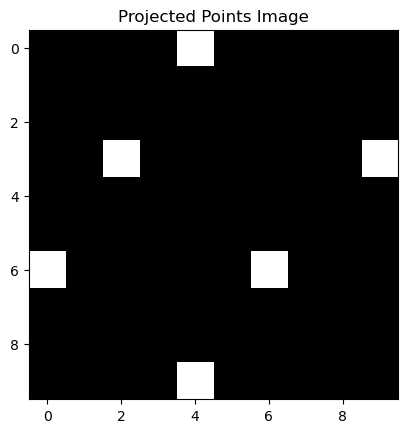

[[2 3]
 [4 0]
 [9 3]
 [6 6]
 [0 6]
 [2 3]
 [6 6]
 [4 9]]


In [17]:
test = image_projection(projects,(10,10))
print(test)

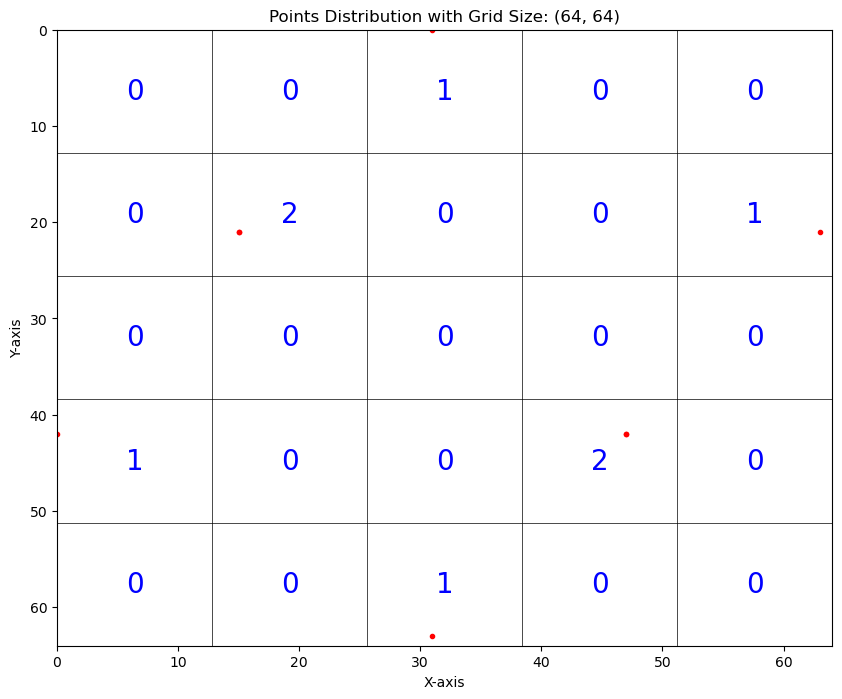

[0 0 1 0 0]
[0 2 0 0 1]


In [18]:
teset = cluster_per_cell(projects,(64,64),(5,5))
print(teset[0])
print(teset[1])

# Test code

In [20]:
def generate_sphere_points(num_points):
    n = set()
    radius = 1
    
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    for i in range(len(x)):
        for j in range(len(x[i])):
            a = (round(x[i][j]),round(y[i][j]),round(z[i][j])) #group value of x,y,z
            n.add(a)
           # print(f"({round(x[i][j])},{round(y[i][j])},{round(z[i][j])})")
    print(f"Number of planes:{len(n)}")
    
    return n

In [21]:
#FUnction that generates normal using points to a sphere. normal should be normalised
def points_projection(structure_coords, num_points):

	# normal vector generation
    # input required(no of points)
    normal = set()
    radius = 1
    
    phi = np.linspace(0, np.pi, num_points)
    theta = np.linspace(0, 2 * np.pi, num_points)
    theta, phi = np.meshgrid(theta, phi)
    
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)

    for i in range(len(x)):
        for j in range(len(x[i])):
            #a = (round(x[i][j]),round(y[i][j]),round(z[i][j])) # group values of x, y, z
            a = (x[i][j],y[i][j],z[i][j])
            normal.add(a)

	# projection part!!!
	# assign structure coords into z
    z = np.array(structure_coords)   
    
	
    all_projected_points = []
    
    for i in normal:
        n = np.array(i)
        
        #Find two orthogonal vectors u and v (both orthogonal to n)
        #Calc value for t (random vector), ensuring not a scaled version of n
        if n[0] != 0:
            t = np.array([-(n[1]+n[2]) / n[0], 1, 1])
        elif n[1] != 0:
            t = np.array([-(n[0]+n[2]) / n[1], 1, 1])
        else:
            t = np.array([-(n[0]+n[1]) / n[2], 1, 1])
        
        u = np.cross(t,n)
        v = np.cross(n,u)
        
        # Normalize u and v (vector length become 1 unit long)
        u = u / np.linalg.norm(u)
        v = v / np.linalg.norm(v)
        
        vec_mat = np.array([u,v])
        
        #Project structure points onto plane
        #Individual component of normal
        a = n[0]
        b = n[1]
        c = n[2]
        #d = 0 #component of equation of planes

        projected_points = []
        
        for point in z:
            z1, z2, z3 = point
            
            k = (0 - a*z1 - b*z2 - c*z3) / (a**2 + b**2 + c**2) 
            
            p1 = z1 + k*a
            p2 = z2 + k*b
            p3 = z3 + k*c
            
            p = np.array([p1,p2,p3])

            #Convert 3D points to 2D
            p_trans = p.transpose()
            proj_2d = np.dot(vec_mat,p_trans)
            projected_points.append(proj_2d)
            print("done")
        all_projected_points.append(projected_points)

    return np.array(all_projected_points), normal

In [22]:
projects,n = points_projection(z,2)

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


In [23]:
print(projects.shape)

(3, 8, 2)


In [24]:
print(n)

{(1.2246467991473532e-16, -2.999519565323715e-32, -1.0), (1.2246467991473532e-16, 0.0, -1.0), (0.0, 0.0, 1.0)}
